# Predict Students' Dropout and Academic Success (UCI #697)  
### Classification + Explainability (LIME, SHAP) + Counterfactuals (DiCE)

This notebook uses the **UCI ML Repository** dataset **"Predict Students' Dropout and Academic Success" (ID: 697, DOI: 10.24432/C5MC89)** to build a **classification model** and produce **model explanations** using:
- **LIME** (local surrogate explanations)
- **SHAP** (Shapley-value based explanations)
- **DiCE** (counterfactual explanations)

Task: predict the 3-class target (**Dropout / Enrolled / Graduate**).  
Note: **DiCE works best in binary settings**, so we additionally build a *binary* model (**Dropout vs Not-Dropout**) for counterfactuals.

---

In [1]:
# If you're running this in a fresh environment, install dependencies.
# (You can comment this cell out if packages are already installed.)

!pip -q install ucimlrepo xgboost shap lime dice-ml imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 42.1 MB/s eta 0:00:00a 0:00:01


## 1) Load dataset from UCI (via `ucimlrepo`)

In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np

# UCI dataset id
data = fetch_ucirepo(id=697)

X = data.data.features.copy()
y = data.data.targets.copy()

display(X.head())
display(y.head())

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Target column(s):", list(y.columns))
print("Unique classes:", y.iloc[:,0].unique())

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0,0.000000,0,10.8,1.4,1.74
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,0,6,0,0,0.000000,0,10.8,1.4,1.74
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79


,Target
0,Dropout
1,Graduate
2,Dropout
3,Graduate
4,Graduate


X shape: (4424, 36)
y shape: (4424, 1)
Target column(s): ['Target']
Unique classes: ['Dropout' 'Graduate' 'Enrolled']


## 2) Train/test split + preprocessing

We will:
- Detect categorical vs numeric columns
- One-hot encode categorical features
- Scale numeric features for SVM
- Keep preprocessing inside a `Pipeline` (good practice + avoids leakage)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

target_col = y.columns[0]
y_series = y[target_col].astype(str)

# Column types
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

print("Categorical columns:", len(cat_cols))
print("Numeric columns:", len(num_cols))

X_train, X_test, y_train, y_test = train_test_split(
    X, y_series, test_size=0.2, random_state=42, stratify=y_series
)

# Preprocessors
preprocess_for_tree = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)

preprocess_for_svm = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(with_mean=False), num_cols),  # with_mean=False because sparse output may occur
    ],
    remainder="drop"
)

print("Train class distribution:\n", y_train.value_counts(normalize=True))

Categorical columns: 0
Numeric columns: 36
Train class distribution:
 Target
Graduate    0.499294
Dropout     0.321277
Enrolled    0.179429
Name: proportion, dtype: float64


In [4]:
from sklearn.preprocessing import LabelEncoder

# XGBoost (multi-class) expects numeric class labels 0..K-1.
# We'll keep string labels for sklearn models, but create encoded labels for XGBoost only.
le = LabelEncoder()
le.fit(y_train)  # fit on train classes

y_train_enc = le.transform(y_train)
y_test_enc  = le.transform(y_test)

print("Class mapping (encoded -> original):")
for i, c in enumerate(le.classes_):
    print(i, "->", c)

Class mapping (encoded -> original):
0 -> Dropout
1 -> Enrolled
2 -> Graduate


## 3) Models: Decision Tree, Random Forest, SVM, XGBoost

We'll train several models quickly and compare using:
- **Macro F1** (robust under class imbalance)
- **Balanced accuracy**
- Confusion matrix + classification report

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

models = {
    "DecisionTree": Pipeline([
        ("preprocess", preprocess_for_tree),
        ("clf", DecisionTreeClassifier(random_state=42, class_weight="balanced"))
    ]),
    "RandomForest": Pipeline([
        ("preprocess", preprocess_for_tree),
        ("clf", RandomForestClassifier(
            n_estimators=400, random_state=42, class_weight="balanced_subsample", n_jobs=-1
        ))
    ]),
    "SVM(RBF)": Pipeline([
        ("preprocess", preprocess_for_svm),
        ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42))
    ]),
    "XGBoost": Pipeline([
        ("preprocess", preprocess_for_tree),
        ("clf", XGBClassifier(
            n_estimators=600,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            objective="multi:softprob",
            eval_metric="mlogloss",
            random_state=42,
            n_jobs=-1,
        ))
    ]),
}

,model,accuracy,balanced_accuracy,macro_f1,weighted_f1
3,XGBoost,0.778531,0.712331,0.720648,0.773318
1,RandomForest,0.776271,0.688003,0.700668,0.762471
2,SVM(RBF),0.708475,0.685872,0.671592,0.724611
0,DecisionTree,0.655367,0.604622,0.602375,0.661348


Best model by macro F1: XGBoost

Classification report:
               precision    recall  f1-score   support

     Dropout       0.82      0.75      0.78       284
    Enrolled       0.56      0.48      0.52       159
    Graduate       0.82      0.90      0.86       442

    accuracy                           0.78       885
   macro avg       0.73      0.71      0.72       885
weighted avg       0.77      0.78      0.77       885



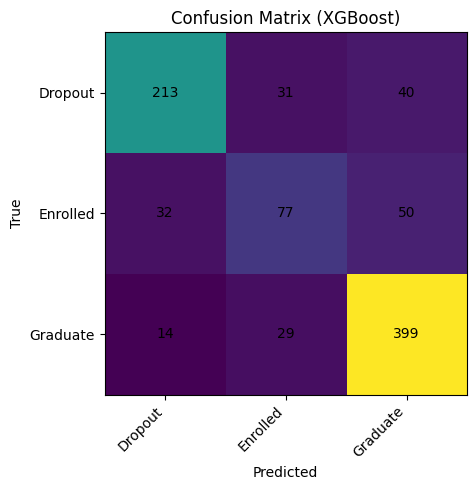

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

results = []

for name, pipe in models.items():
    # XGBoost needs encoded labels, others use string labels
    y_fit = y_train_enc if name == "XGBoost" else y_train
    pipe.fit(X_train, y_fit)
    
    preds = pipe.predict(X_test)
    
    # If XGBoost, decode predictions back to strings
    if name == "XGBoost":
        preds = le.inverse_transform(preds)
    
    results.append({
        "model": name,
        "accuracy": accuracy_score(y_test, preds),
        "balanced_accuracy": balanced_accuracy_score(y_test, preds),
        "macro_f1": f1_score(y_test, preds, average="macro"),
        "weighted_f1": f1_score(y_test, preds, average="weighted"),
    })

results_df = pd.DataFrame(results).sort_values("macro_f1", ascending=False)
display(results_df)

best_name = results_df.iloc[0]["model"]
best_model = models[best_name]
print("Best model by macro F1:", best_name)

# Get best model predictions (decode if XGBoost)
best_preds = best_model.predict(X_test)
if best_name == "XGBoost":
    best_preds = le.inverse_transform(best_preds)

print("\nClassification report:\n", classification_report(y_test, best_preds))

cm = confusion_matrix(y_test, best_preds, labels=sorted(y_test.unique()))
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm)
ax.set_xticks(range(cm.shape[1]))
ax.set_yticks(range(cm.shape[0]))
ax.set_xticklabels(sorted(y_test.unique()), rotation=45, ha="right")
ax.set_yticklabels(sorted(y_test.unique()))
ax.set_title(f"Confusion Matrix ({best_name})")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()

## 4) SHAP explanations (global + local)

We compute SHAP values for **tree-based best model** (RandomForest / XGBoost / DecisionTree).  
If the best model is SVM, we recommend switching to XGBoost for SHAP (KernelExplainer can be slow).

In [8]:
import shap
shap.initjs()

# We'll prefer an XGBoost model for SHAP (fast TreeExplainer).
# If best model isn't tree-based, fall back to XGBoost pipeline trained above.
shap_model_name = best_name if best_name in ["DecisionTree","RandomForest","XGBoost"] else "XGBoost"
shap_pipe = models[shap_model_name]
shap_pipe.fit(X_train, y_train_enc if shap_model_name=='XGBoost' else y_train)

# Get transformed matrices
X_train_trans = shap_pipe.named_steps["preprocess"].fit_transform(X_train)
X_test_trans  = shap_pipe.named_steps["preprocess"].transform(X_test)

# Feature names after preprocessing
ohe = shap_pipe.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = list(ohe.get_feature_names_out(cat_cols)) if len(cat_cols) else []
feature_names = cat_feature_names + num_cols

# Access underlying estimator
est = shap_pipe.named_steps["clf"]

explainer = shap.TreeExplainer(est)
# For multiclass, shap_values can be list (one array per class)
shap_values = explainer.shap_values(X_test_trans)

print("SHAP computed for:", shap_model_name)

SHAP computed for: XGBoost


Classes: ['Dropout', 'Enrolled', 'Graduate']


,feature,mean_abs_shap
30,Curricular units 2nd sem (approved),1.034803
16,Tuition fees up to date,0.427606
24,Curricular units 1st sem (approved),0.314028
12,Admission grade,0.241012
3,Course,0.231895
28,Curricular units 2nd sem (enrolled),0.213623
19,Age at enrollment,0.204988
31,Curricular units 2nd sem (grade),0.195247
33,Unemployment rate,0.171727
35,GDP,0.149698


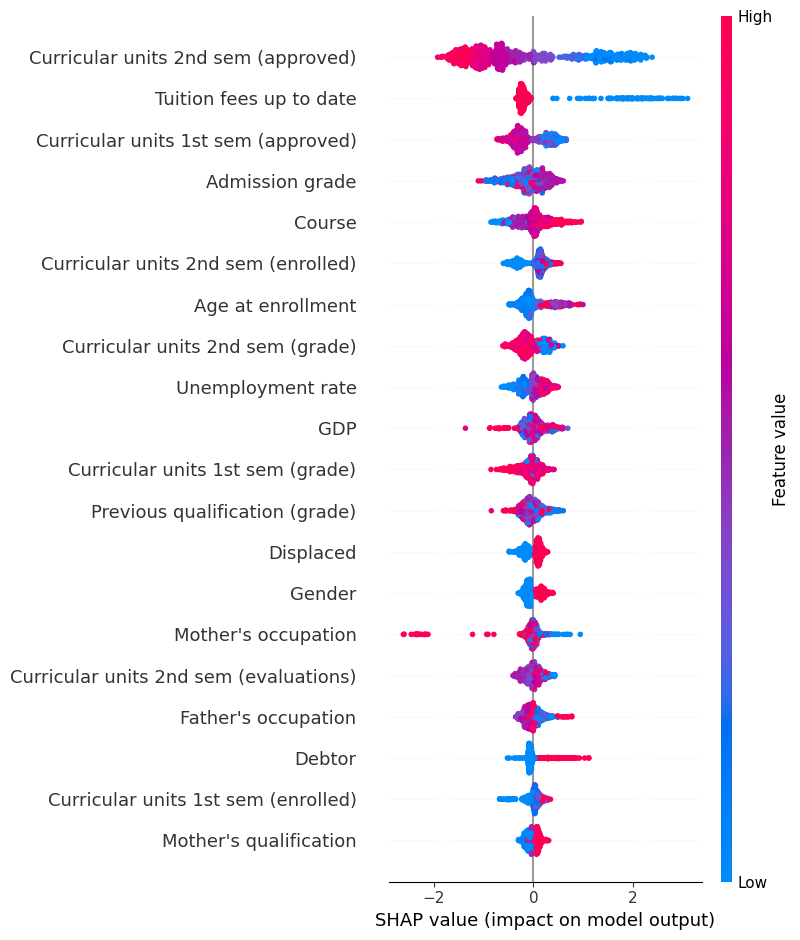

In [12]:
# Global importance (mean |SHAP|) for the class "Dropout" if available, else first class
# Use label encoder to map numeric classes back to strings
classes = le.classes_.tolist()
print("Classes:", classes)

# pick an index for "Dropout" if present
drop_idx = list(classes).index("Dropout") if "Dropout" in classes else 0

# Handle array shape properly: shap_values is (num_samples, num_features, num_classes)
if isinstance(shap_values, list):
    sv = shap_values[drop_idx]
else:
    # Index as (samples, features, classes) -> select class drop_idx
    sv = shap_values[:, :, drop_idx]

mean_abs = np.abs(sv).mean(axis=0)

imp = pd.DataFrame({"feature": feature_names, "mean_abs_shap": mean_abs}).sort_values("mean_abs_shap", ascending=False)
display(imp.head(20))

# SHAP summary plot (top features)
shap.summary_plot(sv, features=X_test_trans, feature_names=feature_names, max_display=20)

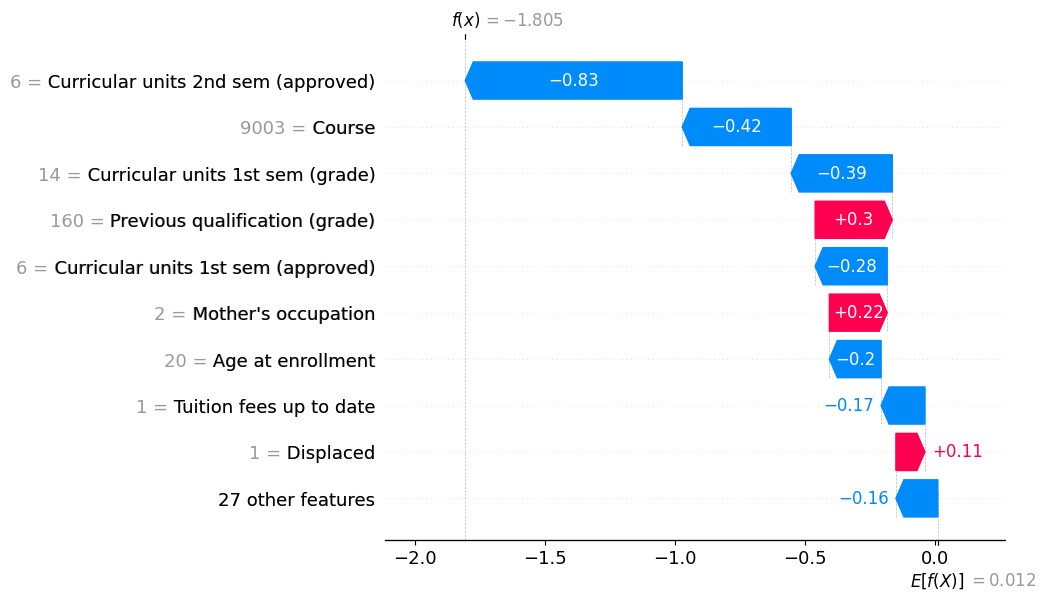

In [14]:
# Local explanation for a single student
idx = 0
x0 = X_test_trans[idx]

# Handle array shape properly: shap_values is (samples, features, classes)
if isinstance(shap_values, list):
    shap.plots.waterfall(shap.Explanation(values=shap_values[drop_idx][idx], 
                                         base_values=explainer.expected_value[drop_idx],
                                         data=x0,
                                         feature_names=feature_names))
else:
    # Index as (samples, features, classes) -> select sample idx and class drop_idx
    shap.plots.waterfall(shap.Explanation(values=shap_values[idx, :, drop_idx], 
                                         base_values=explainer.expected_value[drop_idx],
                                         data=x0,
                                         feature_names=feature_names))

## 5) LIME explanation (local surrogate)

LIME operates on **original feature space**, but needs a model that can accept raw rows and output class probabilities.  
Our sklearn Pipelines satisfy this requirement (`predict_proba` works).

In [15]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# Use best_model; ensure it has predict_proba (all our pipelines do)
lime_pipe = best_model

# If best model is XGBoost, fit using encoded labels and adapt probability output
if best_name == "XGBoost":
    lime_pipe.fit(X_train, y_train_enc)
    class_names = list(le.classes_)
    def predict_proba_fn(Xraw):
        # LIME will pass numpy array; convert to DataFrame with original columns
        Xdf = pd.DataFrame(Xraw, columns=X.columns)
        return lime_pipe.predict_proba(Xdf)
else:
    lime_pipe.fit(X_train, y_train)
    class_names = sorted(y_train.unique())
    def predict_proba_fn(Xraw):
        Xdf = pd.DataFrame(Xraw, columns=X.columns)
        return lime_pipe.predict_proba(Xdf)

# LIME needs numpy arrays; we keep a "raw" matrix but provide feature names
X_train_np = X_train.to_numpy()
X_test_np  = X_test.to_numpy()

explainer_lime = LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=list(X.columns),
    class_names=class_names,
    mode="classification",
    discretize_continuous=True
)

i = 0
exp = explainer_lime.explain_instance(
    data_row=X_test_np[i],
    predict_fn=predict_proba_fn,
    num_features=12
)

exp.show_in_notebook(show_table=True)

## 6) DiCE counterfactuals (Dropout vs Not-Dropout)

DiCE is most straightforward for **binary classification** (desired_class can be 0/1).  
Here we build a binary target:
- **1 = Dropout**
- **0 = Not_Dropout** (Enrolled or Graduate)

Then generate counterfactual examples that change a prediction from Dropout → Not_Dropout.

In [18]:
import dice_ml

# Binary target
y_bin = (y_series == "Dropout").astype(int)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)

# Create a fresh binary XGBoost model (don't reuse the multiclass model)
dice_pipe = Pipeline([
    ("preprocess", preprocess_for_tree),
    ("clf", XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1,
    ))
])
dice_pipe.fit(X_train_b, y_train_b)

# Build DiCE objects
data_dice = dice_ml.Data(
    dataframe=pd.concat([X_train_b, y_train_b.rename("DropoutFlag")], axis=1),
    continuous_features=num_cols,  # treat detected numeric columns as continuous
    outcome_name="DropoutFlag"
)

model_dice = dice_ml.Model(model=dice_pipe, backend="sklearn", model_type="classifier")

dice = dice_ml.Dice(data_dice, model_dice, method="random")

# Pick a test instance predicted as Dropout (1)
proba = dice_pipe.predict_proba(X_test_b)[:,1]
preds = (proba >= 0.5).astype(int)

dropout_indices = np.where(preds == 1)[0]
print("Number of test instances predicted as Dropout:", len(dropout_indices))

if len(dropout_indices) == 0:
    print("No Dropout predictions at 0.5 threshold. Try lowering threshold or pick another instance.")
else:
    query_idx = int(dropout_indices[0])
    query_instance = X_test_b.iloc[[query_idx]]
    print("Query instance index:", query_idx)
    display(query_instance)

    # Generate counterfactuals: desired_class=0 (Not Dropout)
    dice_exp = dice.generate_counterfactuals(
        query_instance,
        total_CFs=5,
        desired_class=0
    )
    dice_exp.visualize_as_dataframe(show_only_changes=True)

Number of test instances predicted as Dropout: 251
Query instance index: 2


,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
2266,1,7,1,9003,1,3,140.0,1,39,39,...,0,1,6,9,1,13.0,0,15.5,2.8,-4.06


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

Query instance (original outcome : 1)


,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,DropoutFlag
0,1,7,1,9003,1,3,140.0,1,39,39,...,1,6,9,1,13.0,0,15.5,2.8,-4.06,1



Diverse Counterfactual set (new outcome: 0)


,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,DropoutFlag
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,17.0,-,8.0,-,-,-,0.0
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,16.0,-,-,-,-,-,0.0
2,-,-,-,-,-,8.0,-,-,-,-,...,-,-,-,14.0,-,-,-,-,-,0.0
3,4.0,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,0.0
4,-,-,-,-,-,-,178.9,-,-,-,...,-,-,-,-,-,-,-,-,-,0.0


## 7) Notes & Good Practice

- If you need **higher recall for Dropout**, tune decision threshold or use class-weighting / focal loss-like objectives.
- For more robust model selection, run **Stratified CV** and tune hyperparameters (e.g., XGBoost depth/eta, SVM C/gamma).
- For fairness/ethics: always validate that sensitive socio-economic attributes do not cause harmful, unjustified decisions.